## 014 Pilot "active" models v1 - learning rate modulation (single subject)

Date: 28.Jul.2022
Updated Data: 02.Aug.2022

### Purpose

Create a model class where momentary craving modulates learning rate.

### Outline of Plan

1. Copy over RetroPrototype from NB#013
2. Copy over Retro0step_RW_EVRPE and Retro2step_RW_EVRPE from NB#013
3. Modify Retro models to incorporate modulation of learning rate based on pre-reward craving
4. Run subjects 7 and 15 - other block, visualize parameter estimates and model comparison

### What we did in this notebook

1. Implement active models where learning rate is modulated by weighted craving
2. Craving weight is named "mod"
   1. Untransformed mod has a normal prior with mean 0, sigma 1
   2. Inverse logit performed to transform between 0 and 1
   3. The transformed mod is translated between -1 and 1 by subtracting 0.5 and multiplying by 2
   4. If this translation isn't done, the sampling fails for some reason.
3. Very promising results! 
   1. Subject 7 - other block has similar performance across all models, visually the predicted ratings look quite similar
   2. Subject 15 - other block has quite different predictions between active and passive models, visually
   3. Subject 15 - other block model comparison reveals that active models are quite a bit better.
4. MAJOR BUG FIXED!!!
   1. The mod parameter was not modulating the craving. Need to rerun some analyses.
5. Active models implemented:
   
Active LR v2
$$
   bias_{craving} = mod*invlogit(craving_{t-1}) 
   \\
   mod \sim LogNormal(0, 0.5)
   \\
   V_t = V_{t-1} + (\alpha + bias) * RPE
$$

Active RPE - based on Konova opioid craving paper
$$
   RPE_t = r_t + bias_{craving} - V_{t-1}
   \\
   bias_{craving} = mod * invlogit(craving_{t-1}) 
   \\
   mod \sim LogNormal(0, 0.5)
$$

Active LR v1 (Hybrid of LR v2 and RPE)
$$
   bias_{craving} = mod*invlogit(craving_{t-1}) 
   \\
   mod \sim LogNormal(0, 0.5)
   \\
   V_t = V_{t-1} + \alpha * bias * RPE
$$

### Overall conclusions
1. After reanalyzing, results are a bit mixed. Active models are not clearly better than passive models in terms of WAIC for craving. In some subjects, they are better in some they are not.
2. Additionally, there are three flavors of active models to test:
   1. Bias*alpha
   2. Bias+alpha
   3. Bias is calculated as an additional reward in the RPE based on current craving
   4. Both can do well depending on the subject.
3. Educated guess - move forward with Active LR v2 (Bias + alpha), referred to as enhanced LR from here on out.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## (Normed) Retrospective prototype class

Assumptions:
1. Both non-normed and normed cravings are calculated and stored
2. Craving inds are calculated
3. Craving means and st. dev. are calculated
4. Beta is the first variable specified, only one beta, and is a required argument
5. Non-sequences in aesara loop DO NOT include beta
6. Sigma in craving_lik equals 1
7. Normed craving retrieved in fit function
8. MAJOR DIFF: 7 rows in aesara loop, Q[left], Q[right], pred_craving, Q[t-1], Q[t-2], PE[t-1], PE[t-2]

In [4]:
class RetroPrototype(ABC):
    def __init__(self, longform, summary, project_dir):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        t_pred_craving = loopvals[:, 2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        # cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        # craving_inds = np.squeeze(np.argwhere(cravings>-1))
        # mask = np.ones(len(craving_inds), dtype=bool)
        # mask[12] = False
        # craving_inds = craving_inds[mask]
        # cravings = cravings[craving_inds]
        # norm_cravings = stats.zscore(cravings)
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act, rew, norm_cravings = self._load_act_rew_craving(pid_num, block)
        with pm.Model() as model:
            priors = self._define_priors()
            craving_sig = pm.Exponential('craving_sig', 2)
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[self.craving_inds-1], sigma=craving_sig, observed=norm_cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)
   
    def load(self, pid_num, block, pid_list, save_path, prefix):
        self.traces[block][pid_list[pid_num]] = az.from_netcdf(f'{save_path}/{prefix}_{pid_num}_{block}.nc')

## Inheritance models

### RW Models

In [9]:
class Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two

In [10]:
class Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six

In [11]:
class Activev1_Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the craving from prev trial
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        # untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        # mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, mod

In [12]:
class Activev1_Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha*bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        # untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        # mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

In [13]:
class Activev2_Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the craving from prev trial
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        # untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        # mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, mod

In [14]:
class Activev2_Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        # untr_mod = pm.Normal('untr_mod', mu=0, sigma=1)
        # mod = pm.Deterministic('mod', pm.math.invlogit(untr_mod))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

In [15]:
class Active_RPE_Retro0step_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active_RPE_Retro0step_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the craving from prev trial
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r + bias - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha*pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, mod

In [16]:
class Active_RPE_Retro2step_Sep_RW_EVRPE(RetroPrototype):
    def __init__(self, longform, summary, project_dir):
        super().__init__(longform, summary, project_dir)
        self.name = 'Active_RPE_Retro2step_Sep_RW_EVRPE'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r + bias - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha*pe)

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod

## Fit models

In [17]:
passive_0step_model = Retro0step_RW_EVRPE(longform, df_summary, project_dir)
passive_2step_model = Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
activev1_0step_model = Activev1_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
activev1_2step_model = Activev1_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
activev2_0step_model = Activev2_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
activev2_2step_model = Activev2_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)
active_rpe_0step_model = Active_RPE_Retro0step_RW_EVRPE(longform, df_summary, project_dir)
active_rpe_2step_model = Active_RPE_Retro2step_Sep_RW_EVRPE(longform, df_summary, project_dir)

In [41]:
# for pid_num in [16]:
#     activev1_0step_model.fit(pid_num, 'other')
#     activev1_2step_model.fit(pid_num, 'other')
#     activev2_0step_model.fit(pid_num, 'other')
#     activev2_2step_model.fit(pid_num, 'other')
#     passive_0step_model.fit(pid_num, 'other')
#     passive_2step_model.fit(pid_num, 'other')
#     active_rpe_0step_model.fit(pid_num, 'other')
#     active_rpe_2step_model.fit(pid_num, 'other')

In [69]:
# Load instead of fitting
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/14_trace_output/'
for pid_num in [7, 15, 16]:
    activev1_0step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'activev1_0step_model')
    activev1_2step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'activev1_2step_model')
    activev2_0step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'activev2_0step_model')
    activev2_2step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'activev2_2step_model')
    passive_0step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'passive_0step_model')
    passive_2step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'passive_2step_model')
    active_rpe_0step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'active_rpe_0step_model')
    active_rpe_2step_model.load(pid_num, 'other', pid_list, save_path_nb14, 'active_rpe_2step_model')

In [40]:
save_path_nb14 = f'{root_dir}/bayesian_models/slotscraving/exploration/14_trace_output/'
for pid_num in [7, 15, 16]:
    activev1_0step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/activev1_0step_model_{pid_num}_other.nc')
    activev1_2step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/activev1_2step_model_{pid_num}_other.nc')
    activev2_0step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/activev2_0step_model_{pid_num}_other.nc')
    activev2_2step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/activev2_2step_model_{pid_num}_other.nc')
    passive_0step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/passive_0step_model_{pid_num}_other.nc')
    passive_2step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/passive_2step_model_{pid_num}_other.nc')
    active_rpe_0step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/active_rpe_0step_model_{pid_num}_other.nc')
    active_rpe_2step_model.traces['other'][pid_list[pid_num]].to_netcdf(f'{save_path_nb14}/active_rpe_2step_model_{pid_num}_other.nc')


## Output posterior

In [51]:
pid_num = 7

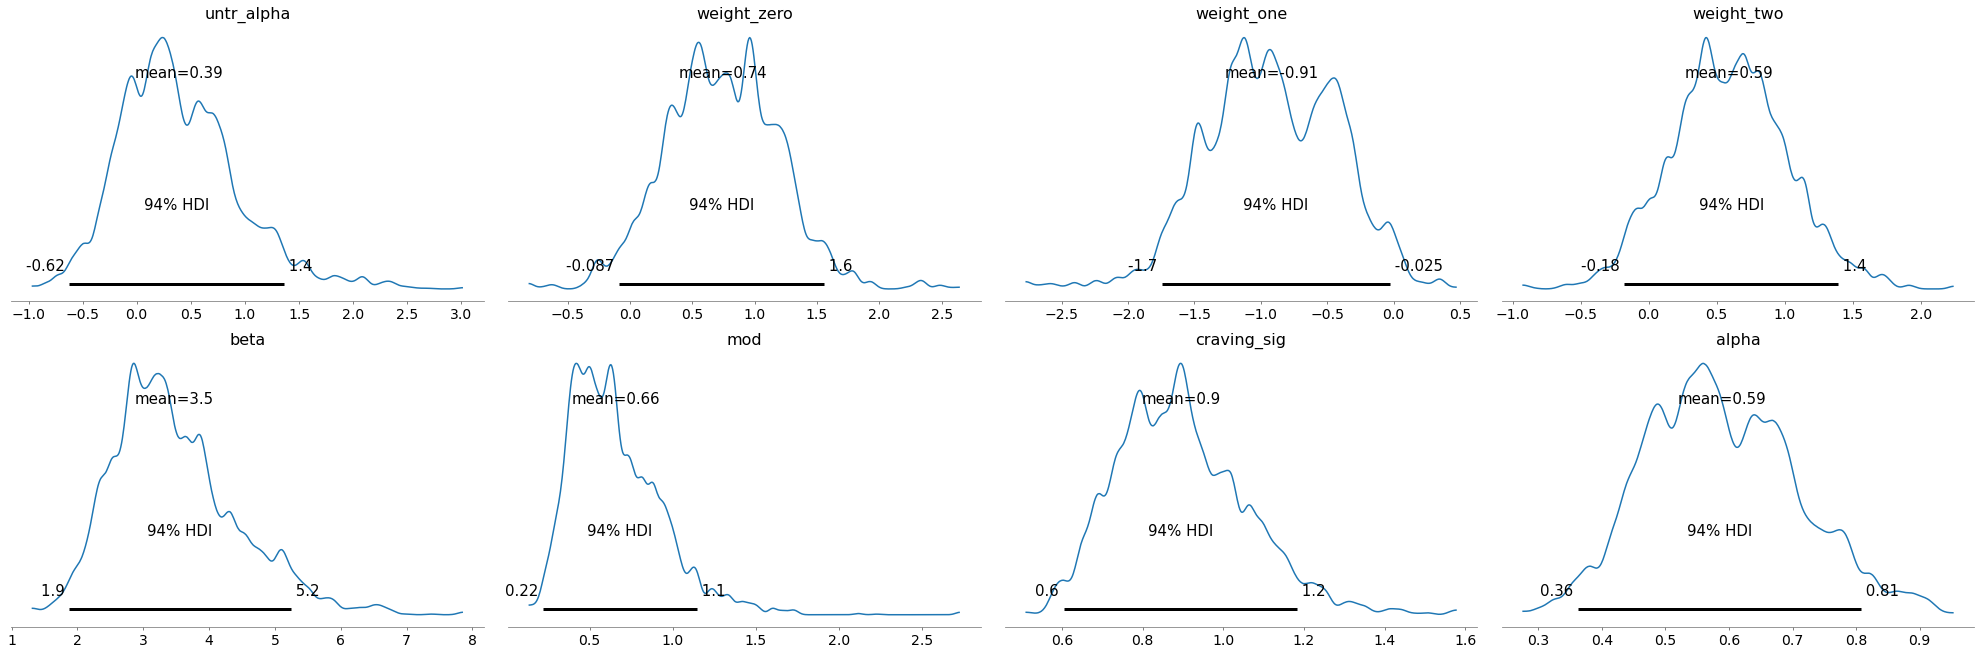

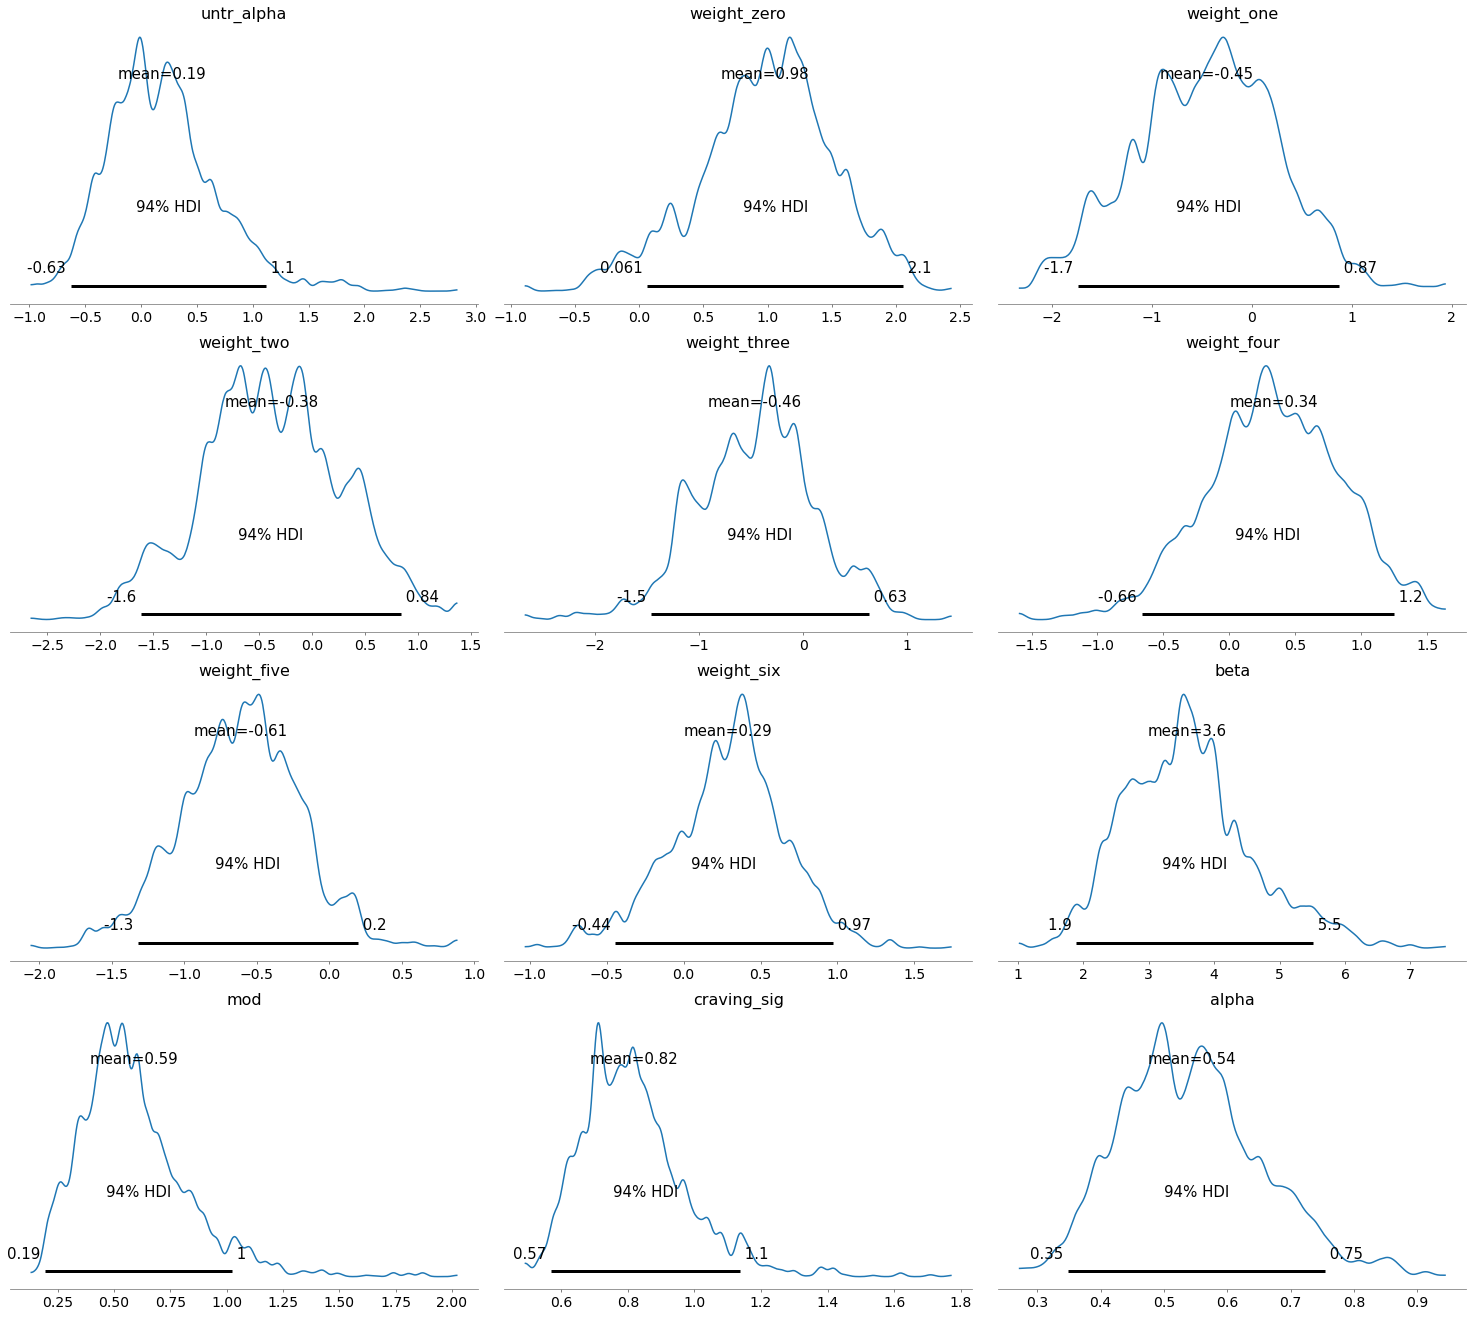

In [52]:
# az.plot_posterior(activev1_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(activev2_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
az.plot_posterior(active_rpe_0step_model.traces['other'][pid_list[pid_num]])
plt.tight_layout()
az.plot_posterior(active_rpe_2step_model.traces['other'][pid_list[pid_num]])
plt.tight_layout()


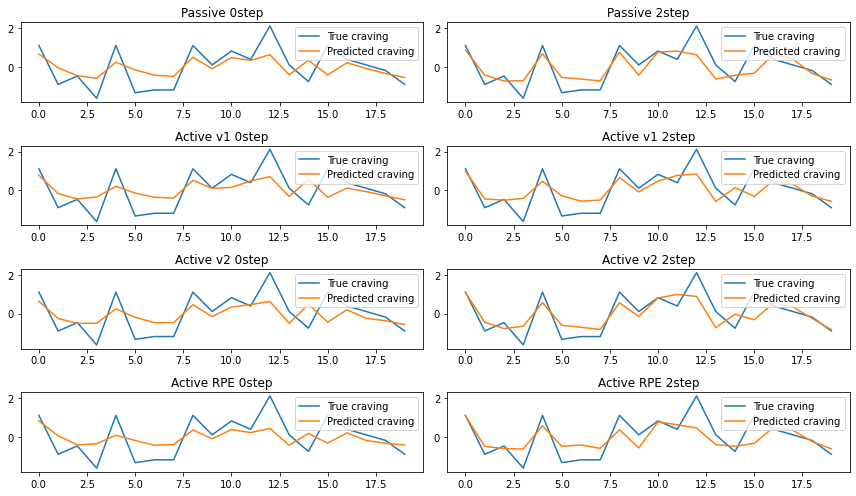

In [53]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 7))

sns.lineplot(
    x=np.arange(passive_0step_model.norm_cravings.shape[2]),
    y=passive_0step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[0, 0],
)
sns.lineplot(
    x=np.arange(passive_0step_model.norm_cravings.shape[2]),
    y=passive_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[0, 0],
)
sns.lineplot(
    x=np.arange(passive_2step_model.norm_cravings.shape[2]),
    y=passive_2step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[0, 1],
)
sns.lineplot(
    x=np.arange(passive_2step_model.norm_cravings.shape[2]),
    y=passive_2step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[0, 1],
)
sns.lineplot(
    x=np.arange(activev1_0step_model.norm_cravings.shape[2]),
    y=activev1_0step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[1, 0],
)
sns.lineplot(
    x=np.arange(activev1_0step_model.norm_cravings.shape[2]),
    y=activev1_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[1, 0],
)
sns.lineplot(
    x=np.arange(activev1_2step_model.norm_cravings.shape[2]),
    y=activev1_2step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[1, 1],
)
sns.lineplot(
    x=np.arange(activev1_2step_model.norm_cravings.shape[2]),
    y=activev1_2step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[1, 1],
)
sns.lineplot(
    x=np.arange(activev2_0step_model.norm_cravings.shape[2]),
    y=activev2_0step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[2, 0],
)
sns.lineplot(
    x=np.arange(activev2_0step_model.norm_cravings.shape[2]),
    y=activev2_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[2, 0],
)
sns.lineplot(
    x=np.arange(activev2_2step_model.norm_cravings.shape[2]),
    y=activev2_2step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[2, 1],
)
sns.lineplot(
    x=np.arange(activev2_2step_model.norm_cravings.shape[2]),
    y=activev2_2step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[2, 1],
)
sns.lineplot(
    x=np.arange(active_rpe_0step_model.norm_cravings.shape[2]),
    y=active_rpe_0step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[3, 0],
)
sns.lineplot(
    x=np.arange(active_rpe_0step_model.norm_cravings.shape[2]),
    y=active_rpe_0step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[3, 0],
)
sns.lineplot(
    x=np.arange(active_rpe_2step_model.norm_cravings.shape[2]),
    y=active_rpe_2step_model.norm_cravings[1, pid_num],
    label='True craving',
    ax=ax[3, 1],
)
sns.lineplot(
    x=np.arange(active_rpe_2step_model.norm_cravings.shape[2]),
    y=active_rpe_2step_model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
    label='Predicted craving',
    ax=ax[3, 1],
)
ax[0, 0].set_title('Passive 0step')
ax[0, 1].set_title('Passive 2step')
ax[1, 0].set_title('Active v1 0step')
ax[1, 1].set_title('Active v1 2step')
ax[2, 0].set_title('Active v2 0step')
ax[2, 1].set_title('Active v2 2step')
ax[3, 0].set_title('Active RPE 0step')
ax[3, 1].set_title('Active RPE 2step')
plt.tight_layout()

## Model comparison of EV and EVRPE

In [56]:
model_comp = az.compare({
        # 'Imm_Passive_RW_EVRPE': imm_model.traces['other'][pid_list[7]],
        'Passive0': passive_0step_model.traces['other'][pid_list[pid_num]],
        'Passive2': passive_2step_model.traces['other'][pid_list[pid_num]],
        'Activev1_0': activev1_0step_model.traces['other'][pid_list[pid_num]],
        'Activev1_2': activev1_2step_model.traces['other'][pid_list[pid_num]],
        'Activev2_0': activev2_0step_model.traces['other'][pid_list[pid_num]],
        'Activev2_2': activev2_2step_model.traces['other'][pid_list[pid_num]],
        'Active_RPE_0': active_rpe_0step_model.traces['other'][pid_list[pid_num]],
        'Active_RPE_2': active_rpe_2step_model.traces['other'][pid_list[pid_num]],
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_en

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Passive2,0,-25.995542,5.445844,0.000000,7.628633e-01,3.607758,0.000000,True,log
Activev2_2,1,-26.813803,6.056586,0.818261,8.517526e-16,3.280736,0.879410,True,log
Activev2_0,2,-26.860742,3.106436,0.865199,0.000000e+00,2.773297,2.002327,True,log
Passive0,3,-26.946219,3.474778,0.950677,0.000000e+00,2.865666,1.865836,True,log
Activev1_0,4,-27.435658,3.261887,1.440116,2.371367e-01,2.719534,2.458740,True,log
Active_RPE_2,5,-27.573940,5.517847,1.578398,2.707243e-15,3.641240,0.746703,True,log
Activev1_2,6,-27.610023,5.261223,1.614480,9.308020e-16,2.944002,1.465765,True,log
Active_RPE_0,7,-27.787206,2.918035,1.791664,1.021405e-14,2.669236,1.673780,True,log


<AxesSubplot:xlabel='Log'>

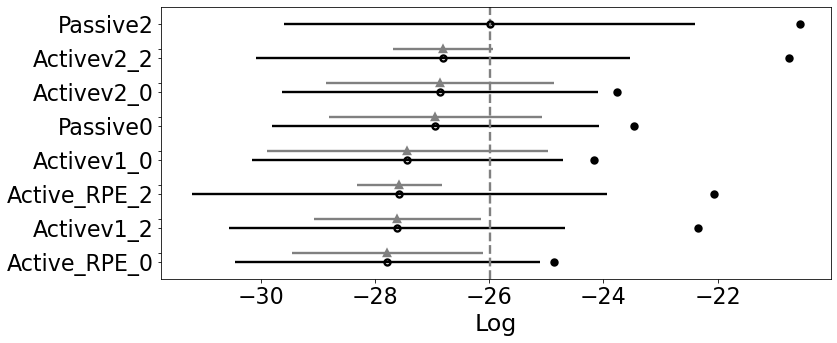

In [57]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))